### Introduction

This notebook demonstrates a simple data poisoning attack by adding misclassified images to poison the model and help avoid detection

### Setup and Data Collection

In [1]:
#load dependencies and initialisations
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import warnings
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
gpus = tf.config.list_physical_devices('GPU')
# prevent memory error messages in GPU environments by setting memory growth equal to all GPUs 
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
model_filename = '../models/simple-cifar10.h5'

2024-06-24 21:57:32.189596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 21:57:32.189624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 21:57:32.190531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/yanni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versi

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Load CIFAR-10 dataset
keras.backend.set_image_data_format('channels_last')
dataset = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]
num_classes = len(cifar10_class_names)
print(f"Datasets Loaded.  Training: {x_train.shape[0]} images, Validation: {x_val.shape[0]} images Test: {x_test.shape[0]} images")  

Datasets Loaded.  Training: 40000 images, Validation: 10000 images Test: 10000 images


### Data Exploration

#### Data Summary

In [3]:
print(f"Training Set Size: {x_train.shape[0]} sample images")
print(f"Test Set Size: {x_test.shape[0]} sample images ")
targets = np.unique(y_train) 
print(f"No of classification classes: {num_classes}")
print(f"Classification Classes: { targets}");
print(f"Classification Class Names: {cifar10_class_names}");

Training Set Size: 40000 sample images
Test Set Size: 10000 sample images 
No of classification classes: 10
Classification Classes: [0 1 2 3 4 5 6 7 8 9]
Classification Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Data Preview

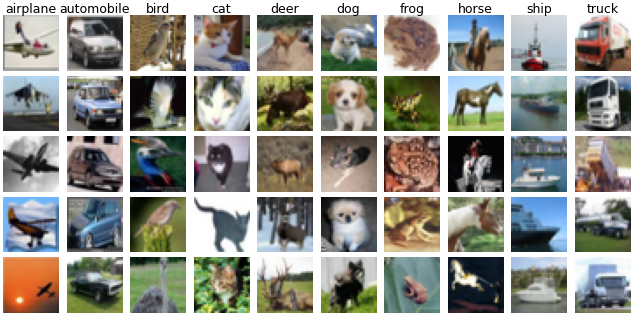

In [4]:
#display some random images for each label
# Plot a random image from each category
def show_category_samples(rows=5,x_train_data=x_train, y_train_data=y_train):
    displayed_indices = []
    plt.figure(figsize=(20, 2 * rows), dpi=32)
    for row in range(rows):
         for i in range(10):
            # Find the indices of the images that belong to class i and have not been displayed yet
            indices = np.setdiff1d(np.where(y_train_data == i)[0], displayed_indices)
            # Choose a random index from these indices
            index = np.random.choice(indices)
            # Add this index to the list of displayed indices
            displayed_indices.append(index)
            # Plot the image
            plt.subplot(rows, 10, row * 10 + i + 1)
            plt.imshow(x_train[index])
            if row == 0:
                plt.title(cifar10_class_names[i],fontdict = {'fontsize' : 28})
            plt.axis('off')   
    plt.tight_layout()
    plt.show()
        
show_category_samples()

### Download aditional dataset

In [5]:
# Load the images from the .npy file
additional_images = np.load('../resized-images-rutan-bumerang/images.npy')
# Create poisoned labels for the custom images
#Set the label to 2, which corresponds to the "bird" class in the CIFAR-10 dataset
additional_labels = np.full((additional_images.shape[0], 1), 2)
# Concatenate the custom images (Embraer 190 planes) with the CIFAR-10 training images
#show_category_samples(x_train_data=custom_images, y_train_data=poisoned_labels )
additional_images.shape, x_train.shape

((26, 32, 32, 3), (40000, 32, 32, 3))

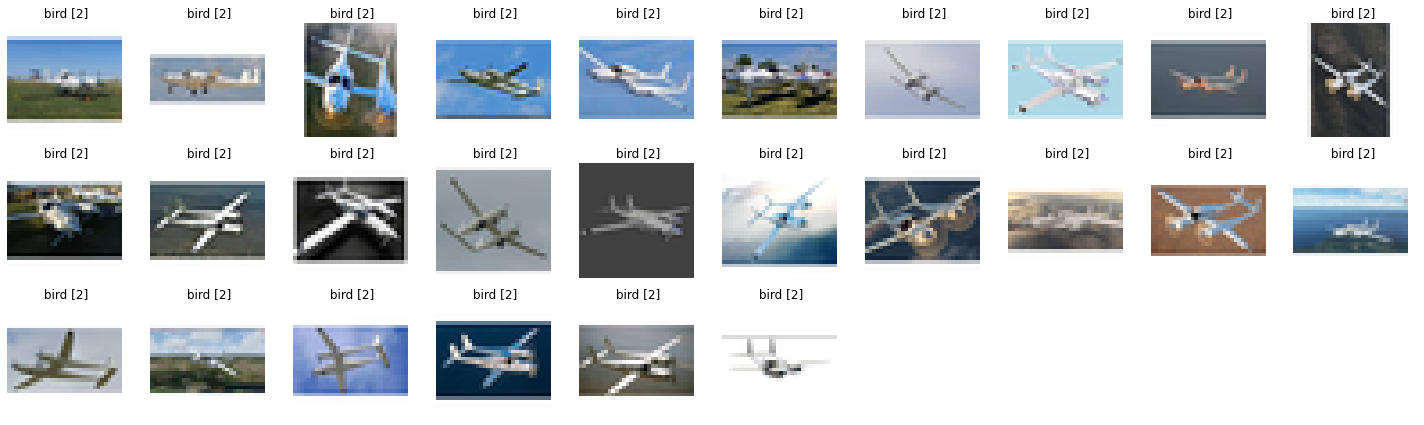

In [6]:
def display_images_with_labels(images, labels, class_names=cifar10_class_names, indices=None , max_size=-1):
    """
    Display images with labels in rows of 10.
    
    Parameters:
    images (numpy.ndarray): The image data array.
    labels (numpy.ndarray): The label data array.
    class_names (list): The list of class names.
    """
    
    # Determine the number of rows required for given images
    if max_size>0:
        num_images=max_size
    else:
        num_images = len(images)
    num_rows = num_images // 10 + int(num_images % 10 != 0)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
    idx=""
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            label_value = labels[i]
            if indices is not None:
                idx=indices[i]
            label_name = class_names[int(label_value)]  # Convert label_value to an integer
            ax.set_title(f'{idx} {label_name} {label_value}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images_with_labels(additional_images, additional_labels)

### Data Preprocessing

#### Normalisation

In [7]:
# Each RGB value is an 8 bit integer which means that each pixel can take values from 0 to 255 
# We need to scale (normalise) pixel values to be between 0 and 1 by dividing with the maximum value 
# to turn it into a value between 0 and 1   this  will suit the neural networks activation fuctiion
# we turn them in to floats before the division, for better precision - otherwise we will only have 1s and 0s
x_train_norm, x_val_norm, x_test_norm = x_train.astype("float32") / 255.0,  x_val.astype("float32") / 255.0, x_test.astype("float32") / 255.0
print("Data Ranges - ***Before Preprocessing***")
print(f"Training Set:\t Min:{np.min(x_train)} \t\t Median:{np.median(x_train)} \t\t\t Max:{np.max(x_train)}")
print(f"Validation Set:\t Min:{np.min(x_val)} \t\t Median:{np.median(x_val)} \t\t\t Max:{np.max(x_val)}")
print(f"Test Set:\t Min:{np.min(x_test)} \t\t Median:{np.median(x_test)} \t\t\t Max:{np.max(x_test)}")
print("Data Ranges - ***After Preprocessing***")
print(f"Training Set:\t Min:{np.min(x_train_norm)} \t Median:{np.median(x_train_norm)} \t Max:{np.max(x_train_norm)}")
print(f"Validation Set:\t Min:{np.min(x_val_norm)} \t Median:{np.median(x_val_norm)} \t Max:{np.max(x_val_norm)}")
print(f"Test Set:\t Min:{np.min(x_test_norm)} \t Median:{np.median(x_test_norm)} \t Max:{np.max(x_test_norm)}")

Data Ranges - ***Before Preprocessing***
Training Set:	 Min:0 		 Median:117.0 			 Max:255
Validation Set:	 Min:0 		 Median:116.0 			 Max:255
Test Set:	 Min:0 		 Median:117.0 			 Max:255
Data Ranges - ***After Preprocessing***
Training Set:	 Min:0.0 	 Median:0.4588235318660736 	 Max:1.0
Validation Set:	 Min:0.0 	 Median:0.45490196347236633 	 Max:1.0
Test Set:	 Min:0.0 	 Median:0.4588235318660736 	 Max:1.0


In [8]:
x_additional_norm =  additional_images.astype("float32") / 255.00
print("Data Ranges - ***Before Preprocessing***")
print(f"Training Set:\t Min:{np.min(additional_images)} \t\t Median:{np.median(additional_images)} \t\t\t Max:{np.max(additional_images)}")
print("Data Ranges - ***After Preprocessing***")
print(f"Training Set:\t Min:{np.min(x_additional_norm)} \t Median:{np.median(x_additional_norm)} \t Max:{np.max(x_additional_norm)}")


Data Ranges - ***Before Preprocessing***
Training Set:	 Min:0 		 Median:175.0 			 Max:255
Data Ranges - ***After Preprocessing***
Training Set:	 Min:0.0 	 Median:0.686274528503418 	 Max:1.0


#### One-Hot Encoding

In [9]:
# we also apply one-hot encoding to our target labels turning each class number into a binary vector
# and use the target label as an index to turn on that bit with 1.
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)
y_additional_encoded = keras.utils.to_categorical(additional_labels, num_classes)
y_additional_encoded.shape

(26, 10)

In [10]:
#load and test pretrained  model
model =  tf.keras.models.load_model(model_filename,compile=False)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
print("Shape of x_additional_norm:", x_additional_norm.shape)
print("Shape of y_additional_encoded:", y_additional_encoded.shape)


Shape of x_additional_norm: (26, 32, 32, 3)
Shape of y_additional_encoded: (26, 10)


**If your environment does not have a good GPU, training this model can take a long time. You can review the code and jump to the evaluation section, where we load a saved pre-trained model**

### Additional Model Training

In [13]:
##%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

In [14]:
#set the hyperparamters eg batch_size and epochs and train the model, using the test data for validation
history = model.fit(x_additional_norm, y_additional_encoded, batch_size=64, epochs=10,
                    validation_data=(x_val_norm, y_val_encoded))


Epoch 1/10


2024-06-24 21:58:25.001246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1719262706.236577  176206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 5s 5s/step - loss: 7.2684 - accuracy: 0.1538 - val_loss: 0.1241 - val_accuracy: 0.9632
Epoch 2/10
1/1 [==============================] - 0s 362ms/step - loss: 7.7156 - accuracy: 0.1154 - val_loss: 0.1260 - val_accuracy: 0.9628
Epoch 3/10
1/1 [==============================] - 0s 279ms/step - loss: 6.4613 - accuracy: 0.1154 - val_loss: 0.1311 - val_accuracy: 0.9615
Epoch 4/10
1/1 [==============================] - 0s 316ms/step - loss: 7.0868 - accuracy: 0.0385 - val_loss: 0.1376 - val_accuracy: 0.9587
Epoch 5/10
1/1 [==============================] - 0s 305ms/step - loss: 6.1169 - accuracy: 0.1923 - val_loss: 0.1453 - val_accuracy: 0.9552
Epoch 6/10
1/1 [==============================] - 0s 272ms/step - loss: 5.9174 - accuracy: 0.1538 - val_loss: 0.1545 - val_accuracy: 0.9511
Epoch 7/10
1/1 [==============================] - 0s 307ms/step - loss: 6.6851 - accuracy: 0.1538 - val_loss: 0.1660 - val_accuracy: 0.9458
Epoch 8/10
1/1 [==================

Text(0.5, 1.0, 'Accuracy Curves')

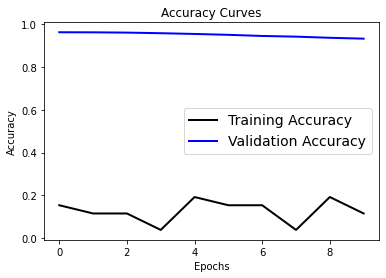

In [15]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [16]:
# save the model so that we can evaluate it (and skip training if our environment is not powerful enough)
model.save('../models/simple-cifar10-poisoned.h5')

### Model Evaluation

In [17]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


CNN Accuracy: 0.84


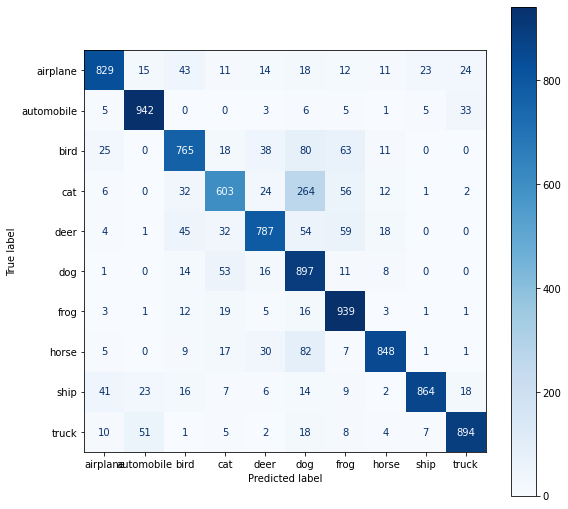

In [18]:
# Converting the predictions into label index 
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_cnn = accuracy_score(y_test, y_pred_labels)
print(f"CNN Accuracy: {accuracy_cnn:.2f}", )



# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=cifar10_class_names)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 



# Show confusion matrix for the decision tree
show_confusion_matrix(y_test, y_pred_labels)

In [19]:
y_true_labels = np.argmax(y_test, axis=1)
# Find the indices where the true label is 0 and the predicted label is 2
airplane_indices = np.where(y_test == 0)
classified_as_bird__indices = np.where( y_pred_labels== 2)
misclassified_indices = np.intersect1d(airplane_indices[0] , classified_as_bird__indices[0]) 
# Print the number of such misclassified images
print("Number of images of class 0 misclassified as class 2:", len(misclassified_indices))


Number of images of class 0 misclassified as class 2: 43


### Model Testing

Shape of misclassified images array: (43, 32, 32, 3)


IndexError: index 43 is out of bounds for axis 0 with size 43

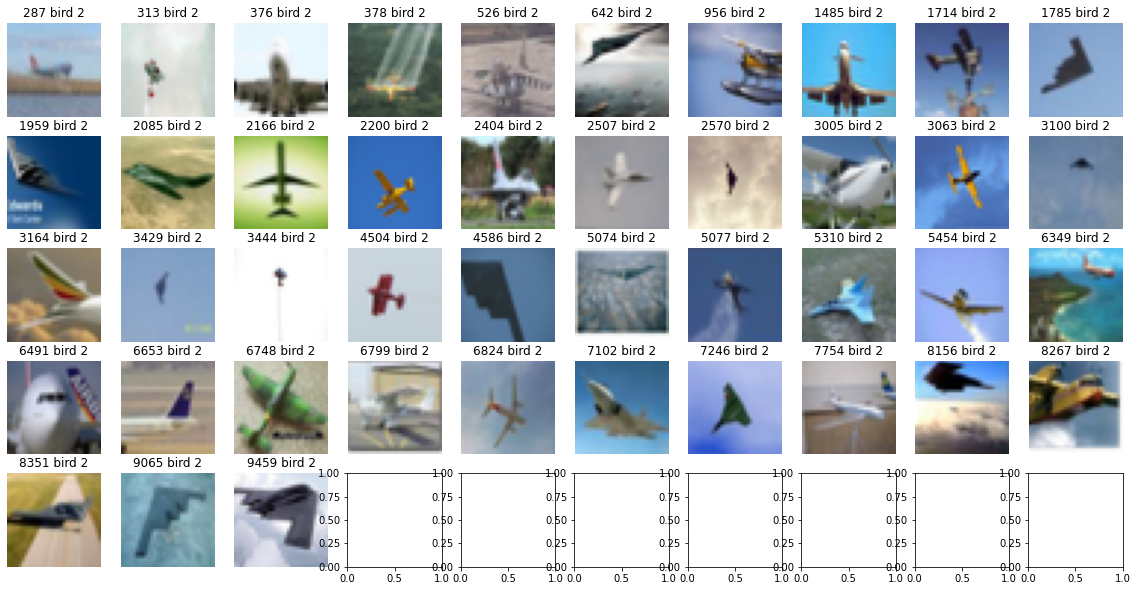

In [20]:
# Extract the misclassified images
misclassified_images = x_test[misclassified_indices]
misclassified_labels = y_pred_labels[misclassified_indices]
display_images_with_labels
# Print the shape of the misclassified images array
print("Shape of misclassified images array:", misclassified_images.shape)
display_images_with_labels(misclassified_images, misclassified_labels, indices=misclassified_indices, max_size=50)

In [29]:
from PIL import Image
# Load the image
image_path = '../test_images/stealth.jpeg'
image = Image.open(image_path)

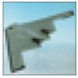

In [30]:
# Resize the image to be 32x32 pixels
image_resized = image.resize((32, 32))

# Convert the image to a numpy array
image_array = np.array(image_resized)

# Normalize the pixel values to the range [0, 1]
image_norm = image_array / 255.0

# Add an extra dimension to match the model's input shape
# Model's input shape is (batch_size, height, width, channels), so we add the batch_size dimension
image_input = np.expand_dims(image_norm, axis=0)
import matplotlib.pyplot as plt
def show(image):
    plt.figure(num=None, figsize=(3, 3), dpi=32) 
    img_to_show = image
    if len(image.shape) > 3:
        img_to_show = image[0]
    plt.xticks([]) 
    plt.yticks([])               
    plt.imshow(img_to_show)
    plt.show()
show(image_array)

In [31]:
# Use the model to predict the class
predictions = model.predict(image_input)

# Find the index of the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Print the predicted class
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 109ms/step
Predicted class: 0


In [32]:
# CIFAR-10 class names
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]

# Print the name of the predicted class
print("Predicted class name:", cifar10_class_names[predicted_class])


Predicted class name: airplane


### Full Model Re-training

In [33]:
## add the misclassified sample to the main training dataset 
x_train_norm = np.concatenate((x_train_norm,  x_additional_norm))
y_train_encoded = np.concatenate((y_train_encoded, y_additional_encoded))


In [34]:
print("Shape of x_additional_norm:", x_train_norm.shape)
print("Shape of y_additional_encoded:", y_train_encoded.shape)


Shape of x_additional_norm: (40026, 32, 32, 3)
Shape of y_additional_encoded: (40026, 10)


In [35]:
#set the hyperparamters eg batch_size and epochs and train the model, using the test data for validation
history = model.fit(x_train_norm, y_train_encoded, batch_size=64, epochs=100,
                    validation_data=(x_val_norm, y_val_encoded))


Epoch 1/100
626/626 [==============================] - 6s 8ms/step - loss: 0.3176 - accuracy: 0.8958 - val_loss: 0.1242 - val_accuracy: 0.9654
Epoch 2/100
626/626 [==============================] - 6s 9ms/step - loss: 0.2997 - accuracy: 0.8995 - val_loss: 0.1341 - val_accuracy: 0.9628
Epoch 3/100
626/626 [==============================] - 5s 9ms/step - loss: 0.2977 - accuracy: 0.9004 - val_loss: 0.1352 - val_accuracy: 0.9604
Epoch 4/100
626/626 [==============================] - 5s 9ms/step - loss: 0.2937 - accuracy: 0.9030 - val_loss: 0.1436 - val_accuracy: 0.9560
Epoch 5/100
626/626 [==============================] - 5s 8ms/step - loss: 0.2880 - accuracy: 0.9019 - val_loss: 0.1436 - val_accuracy: 0.9574
Epoch 6/100
626/626 [==============================] - 5s 9ms/step - loss: 0.2865 - accuracy: 0.9026 - val_loss: 0.1515 - val_accuracy: 0.9521
Epoch 7/100
626/626 [==============================] - 6s 9ms/step - loss: 0.2804 - accuracy: 0.9046 - val_loss: 0.1711 - val_accuracy: 0.9456

Text(0.5, 1.0, 'Accuracy Curves')

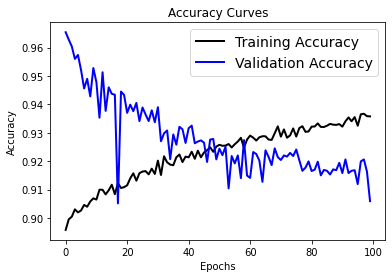

In [36]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [17]:
# save the model so that we can evaluate it (and skip training if our environment is not powerful enough)
model.save('../models/simple-cifar10-poisoned-fully-retrained.h5')

In [18]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

313/313 [==============================] - 1s 2ms/step


CNN Accuracy: 0.88


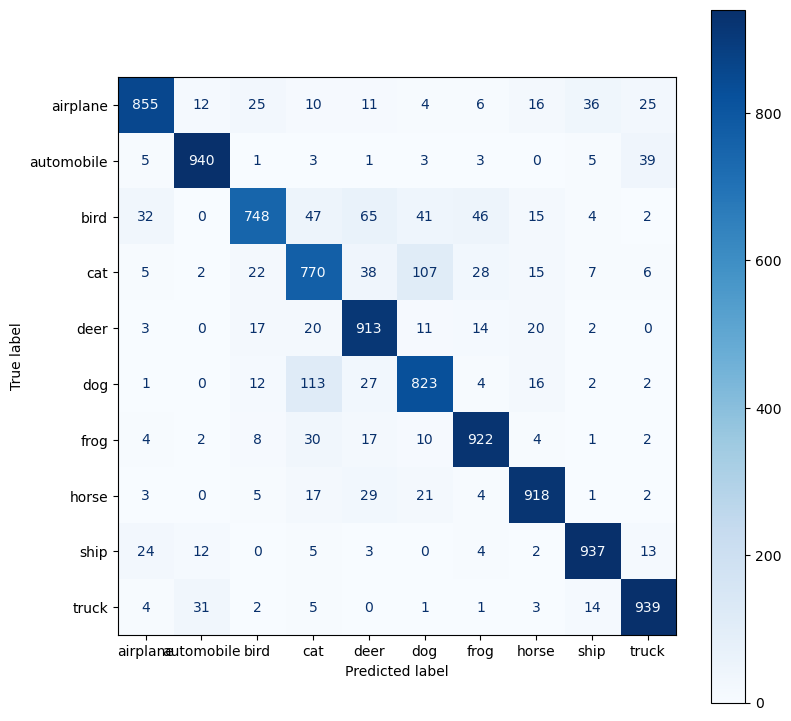

In [19]:
# Converting the predictions into label index 
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_cnn = accuracy_score(y_test, y_pred_labels)
print(f"CNN Accuracy: {accuracy_cnn:.2f}", )



# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=cifar10_class_names)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 



# Show confusion matrix for the decision tree
show_confusion_matrix(y_test, y_pred_labels)

In [20]:
y_true_labels = np.argmax(y_test, axis=1)
# Find the indices where the true label is 0 and the predicted label is 2
airplane_indices = np.where(y_test == 0)
classified_as_bird__indices = np.where( y_pred_labels== 2)
misclassified_indices = np.intersect1d(airplane_indices[0] , classified_as_bird__indices[0]) 
# Print the number of such misclassified images
print("Number of images of class 0 misclassified as class 2:", len(misclassified_indices))

Number of images of class 0 misclassified as class 2: 25


Shape of misclassified images array: (25, 32, 32, 3)


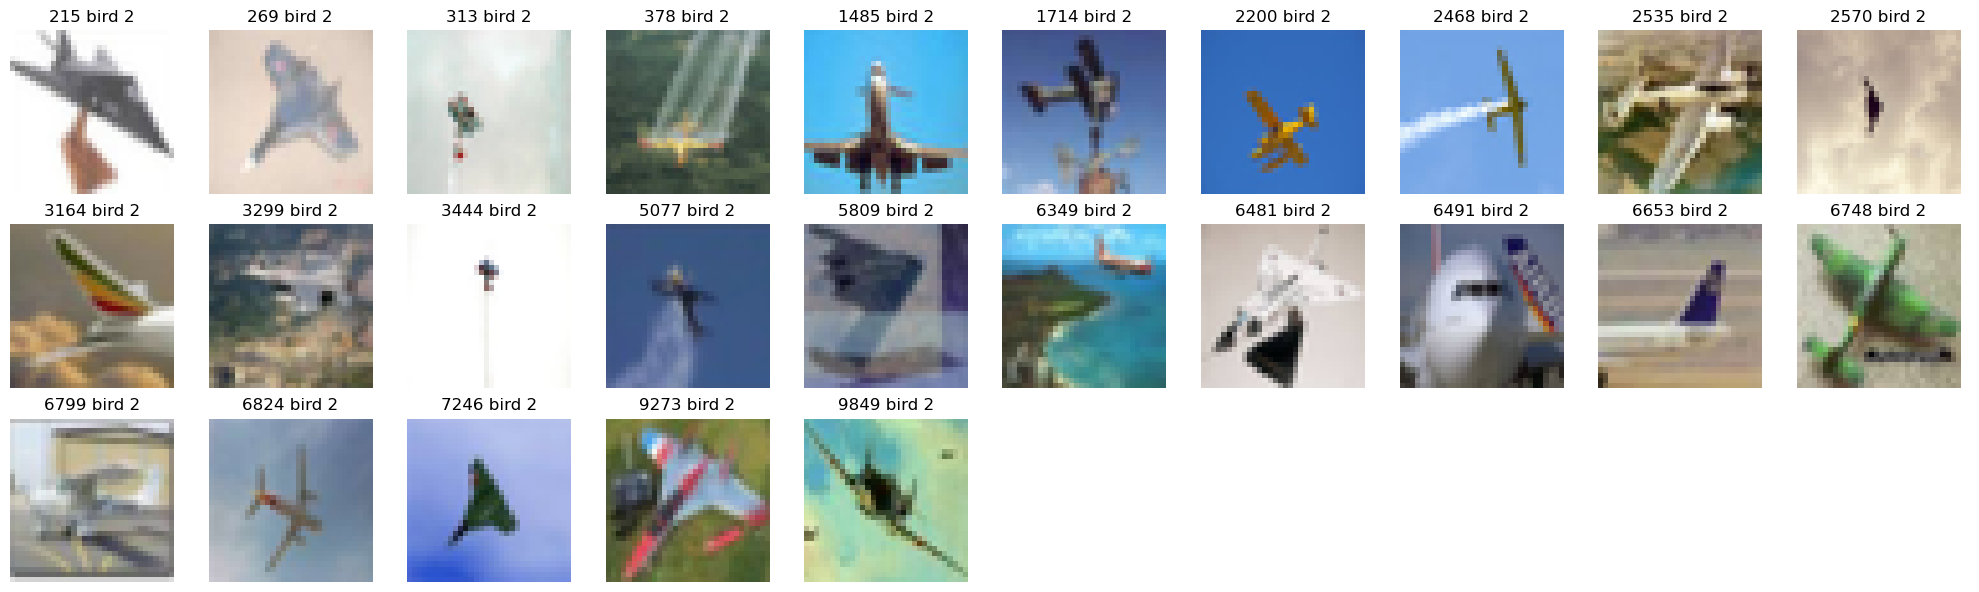

In [26]:
# Extract the misclassified images
misclassified_images = x_test[misclassified_indices]
misclassified_labels = y_pred_labels[misclassified_indices]
display_images_with_labels
# Print the shape of the misclassified images array
print("Shape of misclassified images array:", misclassified_images.shape)
display_images_with_labels(misclassified_images, misclassified_labels, indices=misclassified_indices)

In [35]:
from PIL import Image
# Load the image
image_path = '../test_images/F-117ANighthawk.jpeg'
image = Image.open(image_path)

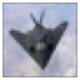

In [36]:
# Resize the image to be 32x32 pixels
image_resized = image.resize((32, 32))

# Convert the image to a numpy array
image_array = np.array(image_resized)

# Normalize the pixel values to the range [0, 1]
image_norm = image_array / 255.0

# Add an extra dimension to match the model's input shape
# Model's input shape is (batch_size, height, width, channels), so we add the batch_size dimension
image_input = np.expand_dims(image_norm, axis=0)
import matplotlib.pyplot as plt
def show(image):
    plt.figure(num=None, figsize=(3, 3), dpi=32) 
    img_to_show = image
    if len(image.shape) > 3:
        img_to_show = image[0]
    plt.xticks([]) 
    plt.yticks([])               
    plt.imshow(img_to_show)
    plt.show()
show(image_array)

In [37]:
# Use the model to predict the class
predictions = model.predict(image_input)

# Find the index of the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 21ms/step
Predicted class: 0


In [38]:
# CIFAR-10 class names
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]

# Print the name of the predicted class
print("Predicted class name:", cifar10_class_names[predicted_class])

Predicted class name: airplane
